1. Em um banco de dados sqlite, crie uma tabela contendo 5.000 entradas utilizando dados sintéticos.
A tabela deve conter os campos `cpf`, `nome_completo`, `emprego_atual`, `data_nascimento`, `situacao_civil` (com os possíveis valores: 'solteiro(a)', 'casado(a)', 'divorciado(a)'), ' e `endereco`, e uma variável booleana `cliente_especial` com 5% de chance ter o valor True. Você pode usar a biblioteca faker do python para gerar esses dados. Durante a entrevista, discutiremos como esses dados foram gerados, então guarde os scripts utilizados.

In [1]:
from faker import Faker
import random
import sqlite3

In [2]:
situacao_civil = ['Solteiro(a)', 'Casado(a)', 'Divorsiado(a)']
fake = Faker('pt_BR')
Faker.seed(0)

cpf = fake.cpf()
nome_completo = fake.name()
emprego_atual = fake.job()
data_nascimento = fake.date_of_birth(minimum_age = 18, maximum_age = 65)
situacao_civil = random.choice(situacao_civil)
endereco = fake.address()
cliente_especial = random.choices([True, False], weights=[0.05, 0.95])[0]


print(cpf)
print(nome_completo)
print(emprego_atual)
print(data_nascimento)
print(situacao_civil)
print(endereco)
print(cliente_especial)

690.243.518-98
Sr. Thiago Carvalho
Escoteiro
1967-11-09
Solteiro(a)
Setor Juan das Neves, 2
São Luiz
78156-593 Macedo de Moreira / GO
False


In [3]:
def gerar_dados_sinteticos(n):

    fake = Faker('pt_BR')

    cpf = fake.cpf()
    nome_completo = fake.name()
    emprego_atual = fake.job()
    data_nascimento = fake.date_of_birth(minimum_age = 18, maximum_age = 65)
    situacao_civil = random.choice(['Solteiro(a)', 'Casado(a)', 'Divorsiado(a)'])
    endereco = fake.address()
    cliente_especial = str(random.choices([1, 0], weights=[0.05, 0.95])[0])

    dados = (cpf, nome_completo, emprego_atual, data_nascimento, situacao_civil, endereco, cliente_especial)
    return dados
gerar_dados_sinteticos(0)

('089.753.621-59',
 'Sr. Luan Santos',
 'Atendente',
 datetime.date(1971, 5, 7),
 'Divorsiado(a)',
 'Setor Machado, 2\nLagoinha Leblon\n14841-858 Pereira / PI',
 '0')

In [4]:
try:
    conn = sqlite3.connect('Base.db')
    cursor = conn.cursor()

    cursor.execute("""
        CREATE TABLE IF NOT EXISTS "clientes"(
            "id" INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT,
            "cpf" TEXT NOT NULL UNIQUE,
            "nome_completo" TEXT NOT NULL,
            "emprego_atual" TEXT NOT NULL,
            "data_nascimento" DATE NOT NULL,
            "situacao_civil" TEXT NOT NULL,
            "endereco" TEXT NOT NULL,
            "cliente_especial" INTEGER NOT NULL CHECK (cliente_especial IN (0, 1))
    );
    """)

    clientes = []
    for i in range(5000):
        novo_cliente = gerar_dados_sinteticos(i)
        while True:
            try:
                cursor.execute('''INSERT INTO clientes (cpf, nome_completo, emprego_atual, data_nascimento, situacao_civil, endereco, cliente_especial) 
                               VALUES (?, ?, ?, ?, ?, ?, ?)''', novo_cliente)
                conn.commit()
                clientes.append(novo_cliente)
                break
            except sqlite3.IntegrityError:  # Captura a exceção de violação de restrição UNIQUE
                novo_cliente = gerar_dados_sinteticos(i)

except Exception as exception:
    if cursor:
        conn.rollback()
    raise exception
    
finally:
    if cursor:
        conn.close()

2. Utilizando as bibliotecas Pandas, Numpy, Scipy, e Scikit-Learn, crie uma pipeline que contemple tratamento de dados, busca de hiperparâmetros, treinamento de modelo e avaliação para as três seguintes classes de modelos: 

    - Regressão Logística
    - Árvore de Decisão
    - SVM

    A pipeline será executada durante a conversa em seu computador, portanto é importante ter o ambiente corretamente configurado.

# PREPARAÇÃO DOS DADOS

In [17]:
import sqlite3
import pandas as pd
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
from category_encoders.one_hot import OneHotEncoder
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler #OneHotEncoder
from sklearn.model_selection import cross_val_predict
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE



In [8]:
try:
    conn = sqlite3.connect('Base.db')
    df = pd.read_sql_query("SELECT * FROM clientes",conn)
except Exception as exception:
    if conn:
        conn.close()
    raise exception
finally:
    if conn:
        conn.close()

df.head()

id             cpf      nome_completo                 emprego_atual  \
0   1  947.083.256-65  Francisco Correia                    Cozinheira   
1   2  751.240.369-07    Joaquim Almeida        Engenheiro mecatrônico   
2   3  916.027.453-07    Francisco Silva       Catador de carangueijos   
3   4  634.258.190-89     Emanuel Castro                Gestor público   
4   5  071.259.643-70      Maria Pimenta  Especialista em agronegócios   

  data_nascimento situacao_civil  \
0      1960-08-03  Divorsiado(a)   
1      1966-04-26  Divorsiado(a)   
2      1990-12-16  Divorsiado(a)   
3      1994-05-18  Divorsiado(a)   
4      2004-03-03  Divorsiado(a)   

                                            endereco  cliente_especial  
0  Chácara Rocha, 12\nPlanalto\n86848339 Pacheco ...                 0  
1  Loteamento Lima, 2\nVila Satélite\n30989101 Pe...                 0  
2  Viela Almeida, 269\nFloresta\n13145-620 Aparec...                 0  
3  Praia de Rios\nConjunto Providencia\n76984564 ...                 1  
4  Vale de Cardoso, 76\nPalmares\n09352337 Santos...                 0

In [9]:
def extrair_endereco(endereco):
    partes = endereco.split('\n')
    
    # Se houver pelo menos três partes (rua, bairro e cidade/estado)
    if len(partes) >= 3:
        rua_numero = partes[0].split(',')
        if len(rua_numero) == 2:
            rua = rua_numero[0].strip()
        else:
            rua = partes[0].strip()
            
        
        bairro = partes[1].strip()
        cidade_cep = partes[2].split(' ')
        cep = cidade_cep[0] 
        cidade = ' '.join(cidade_cep[1:-2])
        estado = cidade_cep[-1]
        
        return rua, bairro, cidade, estado, cep
    else:
        return None, None, None, None, None

In [10]:
endereco = df['endereco']
ruas, bairros, cidades, estados, ceps = [], [], [], [], []

for i in range(len(endereco)):
    rua, bairro, cidade, estado, cep = extrair_endereco(endereco[i])
    ruas.append(rua)
    bairros.append(bairro)
    cidades.append(cidade)
    estados.append(estado)
    ceps.append(cep)


df['rua'] = ruas
df['bairro'] = bairros
df['cidade'] = cidades
df['estado'] = estados
df['CEP'] = ceps

df.head()

id             cpf      nome_completo                 emprego_atual  \
0   1  947.083.256-65  Francisco Correia                    Cozinheira   
1   2  751.240.369-07    Joaquim Almeida        Engenheiro mecatrônico   
2   3  916.027.453-07    Francisco Silva       Catador de carangueijos   
3   4  634.258.190-89     Emanuel Castro                Gestor público   
4   5  071.259.643-70      Maria Pimenta  Especialista em agronegócios   

  data_nascimento situacao_civil  \
0      1960-08-03  Divorsiado(a)   
1      1966-04-26  Divorsiado(a)   
2      1990-12-16  Divorsiado(a)   
3      1994-05-18  Divorsiado(a)   
4      2004-03-03  Divorsiado(a)   

                                            endereco  cliente_especial  \
0  Chácara Rocha, 12\nPlanalto\n86848339 Pacheco ...                 0   
1  Loteamento Lima, 2\nVila Satélite\n30989101 Pe...                 0   
2  Viela Almeida, 269\nFloresta\n13145-620 Aparec...                 0   
3  Praia de Rios\nConjunto Providencia\n76984564 ...                 1   
4  Vale de Cardoso, 76\nPalmares\n09352337 Santos...                 0   

               rua                bairro                cidade estado  \
0    Chácara Rocha              Planalto      Pacheco Paulista     PB   
1  Loteamento Lima         Vila Satélite               Pereira     TO   
2    Viela Almeida              Floresta  Aparecida de Peixoto     AM   
3    Praia de Rios  Conjunto Providencia                Novais     RR   
4  Vale de Cardoso              Palmares          Santos Verde     PA   

         CEP  
0   86848339  
1   30989101  
2  13145-620  
3   76984564  
4   09352337

In [11]:
df['data_nascimento'] = pd.to_datetime(df['data_nascimento'])
hoje = datetime.date.today()
df['idade'] = df['data_nascimento'].apply(lambda x: hoje.year - x.year - ((hoje.month, hoje.day) < (x.month, x.day)))
df.head()


id             cpf      nome_completo                 emprego_atual  \
0   1  947.083.256-65  Francisco Correia                    Cozinheira   
1   2  751.240.369-07    Joaquim Almeida        Engenheiro mecatrônico   
2   3  916.027.453-07    Francisco Silva       Catador de carangueijos   
3   4  634.258.190-89     Emanuel Castro                Gestor público   
4   5  071.259.643-70      Maria Pimenta  Especialista em agronegócios   

  data_nascimento situacao_civil  \
0      1960-08-03  Divorsiado(a)   
1      1966-04-26  Divorsiado(a)   
2      1990-12-16  Divorsiado(a)   
3      1994-05-18  Divorsiado(a)   
4      2004-03-03  Divorsiado(a)   

                                            endereco  cliente_especial  \
0  Chácara Rocha, 12\nPlanalto\n86848339 Pacheco ...                 0   
1  Loteamento Lima, 2\nVila Satélite\n30989101 Pe...                 0   
2  Viela Almeida, 269\nFloresta\n13145-620 Aparec...                 0   
3  Praia de Rios\nConjunto Providencia\n76984564 ...                 1   
4  Vale de Cardoso, 76\nPalmares\n09352337 Santos...                 0   

               rua                bairro                cidade estado  \
0    Chácara Rocha              Planalto      Pacheco Paulista     PB   
1  Loteamento Lima         Vila Satélite               Pereira     TO   
2    Viela Almeida              Floresta  Aparecida de Peixoto     AM   
3    Praia de Rios  Conjunto Providencia                Novais     RR   
4  Vale de Cardoso              Palmares          Santos Verde     PA   

         CEP  idade  
0   86848339     63  
1   30989101     58  
2  13145-620     33  
3   76984564     29  
4   09352337     20

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                5000 non-null   int64         
 1   cpf               5000 non-null   object        
 2   nome_completo     5000 non-null   object        
 3   emprego_atual     5000 non-null   object        
 4   data_nascimento   5000 non-null   datetime64[ns]
 5   situacao_civil    5000 non-null   object        
 6   endereco          5000 non-null   object        
 7   cliente_especial  5000 non-null   int64         
 8   rua               5000 non-null   object        
 9   bairro            5000 non-null   object        
 10  cidade            5000 non-null   object        
 11  estado            5000 non-null   object        
 12  CEP               5000 non-null   object        
 13  idade             5000 non-null   int64         
dtypes: datetime64[ns](1), in

In [13]:
df.describe()

id             data_nascimento  cliente_especial        idade
count  5000.000000                        5000        5000.00000  5000.000000
mean   2500.500000  1982-07-15 06:38:35.520000           0.05400    41.309600
min       1.000000         1958-05-15 00:00:00           0.00000    18.000000
25%    1250.750000         1970-06-05 12:00:00           0.00000    29.000000
50%    2500.500000         1982-08-15 12:00:00           0.00000    41.000000
75%    3750.250000         1994-09-07 00:00:00           0.00000    53.000000
max    5000.000000         2006-05-05 00:00:00           1.00000    65.000000
std    1443.520003                         NaN           0.22604    13.895581

In [14]:
df.select_dtypes(include = 'object').describe()

cpf        nome_completo emprego_atual situacao_civil  \
count             5000                 5000          5000           5000   
unique            5000                 4716           747              3   
top     947.083.256-65  Maria Isis da Cunha     Professor  Divorsiado(a)   
freq                 1                    3            18           1738   

                                                 endereco           rua  \
count                                                5000          5000   
unique                                               5000          4483   
top     Chácara Rocha, 12\nPlanalto\n86848339 Pacheco ...  Vereda Costa   
freq                                                    1             5   

           bairro cidade estado       CEP  
count        5000   5000   5000      5000  
unique        482   1890     27      5000  
top     Dom Bosco  Silva     GO  86848339  
freq           24     37    227         1

In [15]:
df['cliente_especial'].value_counts()


cliente_especial
0    4730
1     270
Name: count, dtype: int64

In [16]:
df_transformado = df.copy()
df_transformado = df_transformado[['emprego_atual', 'idade', 'situacao_civil', 'bairro', 'cidade', 'estado', 'cliente_especial']]
df_transformado.head()

emprego_atual  idade situacao_civil                bairro  \
0                    Cozinheira     63  Divorsiado(a)              Planalto   
1        Engenheiro mecatrônico     58  Divorsiado(a)         Vila Satélite   
2       Catador de carangueijos     33  Divorsiado(a)              Floresta   
3                Gestor público     29  Divorsiado(a)  Conjunto Providencia   
4  Especialista em agronegócios     20  Divorsiado(a)              Palmares   

                 cidade estado  cliente_especial  
0      Pacheco Paulista     PB                 0  
1               Pereira     TO                 0  
2  Aparecida de Peixoto     AM                 0  
3                Novais     RR                 1  
4          Santos Verde     PA                 0

# Regressao Logistica Sem Pipeline

In [18]:
def balanceamento():

    one_hot_encoder = OneHotEncoder(cols = df_transformado.drop(columns =['idade','cliente_especial']).columns.values)
    df_ml = one_hot_encoder.fit_transform(df_transformado)
    df_ml.head()

    X = df_ml.drop(columns = 'cliente_especial')
    y = df_ml['cliente_especial']

    smote_bal = SMOTE(random_state = 42)

    X_bal, y_bal = smote_bal.fit_resample(X, y)

    return X_bal, y_bal

In [19]:
X_bal, y_bal = balanceamento()
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_bal, y_bal, test_size = 0.30, random_state = 42)

In [20]:
standard_scaler = StandardScaler()
pca = PCA(.95)

X_train_lr['idade'] = standard_scaler.fit_transform(X_train_lr['idade'].values.reshape(-1, 1))
X_test_lr['idade'] = standard_scaler.fit_transform(X_test_lr['idade'].values.reshape(-1, 1))

X_train_lr_pca = pca.fit_transform(X_train_lr)
X_test_lr_pca = pca.transform(X_test_lr)

In [222]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
    'max_iter': [100, 500, 1000]
}

modelo = LogisticRegression()     
            
grid_search = GridSearchCV(modelo, param_grid, cv = 1, scoring='accuracy')
grid_search.fit(X_bal, y_bal)
print("Melhores hiperparâmetros:", grid_search.best_params_)
print("Acurácia:", grid_search.best_score_)

c:\Users\lucas\OneDrive\Área de Trabalho\Desafio_itau\venv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lucas\OneDrive\Área de Trabalho\Desafio_itau\venv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lucas\OneDrive\Área de Trabalho\Desafio_itau\venv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lucas\OneDrive\Área de Trabalho\Desafio_itau\venv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\lucas\OneDrive\Área de Trabalho\Desafio_itau\venv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reac

In [ ]:
best_model = grid_search.best_estimator_

modelo = best_model.fit(X_train_lr_pca, y_train_lr)

In [21]:
modelo = LogisticRegression()
modelo.fit(X_train_lr_pca, y_train_lr)

LogisticRegression()

In [22]:
modelo.score(X_train_lr_pca, y_train_lr)

0.9527333131984295

In [23]:
predict_lr = modelo.predict(X_test_lr_pca)

acuracia_lr = accuracy_score(y_test_lr, predict_lr)
acuracia_lr

0.9541930937279774

In [24]:
print(classification_report(y_test_lr, predict_lr))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      1429
           1       1.00      0.91      0.95      1409

    accuracy                           0.95      2838
   macro avg       0.96      0.95      0.95      2838
weighted avg       0.96      0.95      0.95      2838



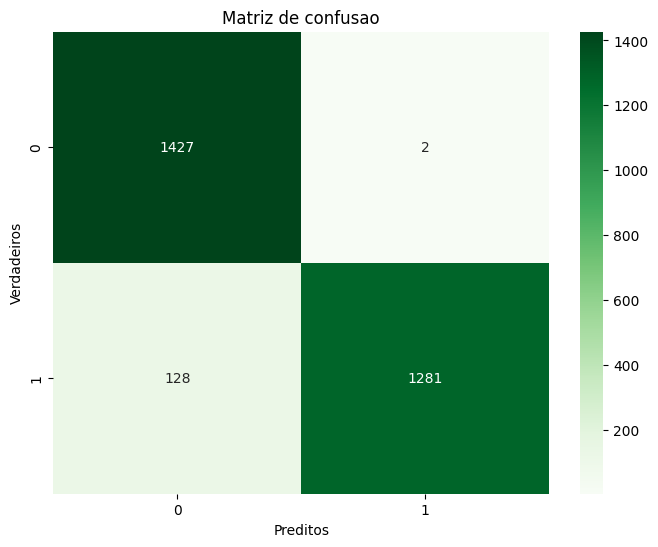

In [25]:
conf_matrix = confusion_matrix(y_test_lr, predict_lr)

# Plote a matriz de confusão usando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens")
plt.xlabel('Preditos')
plt.ylabel('Verdadeiros')
plt.title('Matriz de confusao')
plt.show()

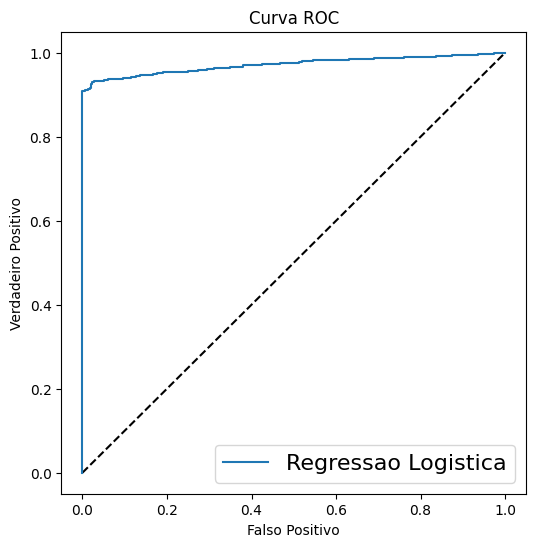

area sob a curva:  0.9712892377850875


In [27]:
y_score = modelo.predict_proba(X_test_lr_pca)
fpr, tpr, threshold = roc_curve(y_test_lr, y_score[:, 1])

fig = plt.figure(figsize = (6, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label = "Regressao Logistica")
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadeiro Positivo')
plt.title('Curva ROC')
plt.legend(loc="lower right", fontsize=16)
plt.show()
print('area sob a curva: ', auc(fpr, tpr))


# Regressao Logistica com Pipeline

In [32]:

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline

In [33]:
X = df_transformado.drop(columns = ['cliente_especial'])
y = df_transformado['cliente_especial']



In [ ]:
cat_nominal = X.drop(columns = 'idade').columns.values
numerica = X['idade'].values

cat_nominal_transformer = Pipeline(steps = [
    ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))
])


preprocessor = ColumnTransformer(transformers=[
    ('cat_nominal', cat_nominal_transformer, cat_nominal)
])

pipe = make_pipeline(
    preprocessor,
    SMOTE(random_state = 42),
    StandardScaler(with_mean = False),
    PCA(svd_solver='arpack'),
    LogisticRegression()
    
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

pipe.fit(X_train, y_train)


In [216]:
pipe.score(X_train, y_train)

1.0

In [217]:
predict = pipe.predict(X_test)

acuracia = accuracy_score(y_test, predict)
acuracia

0.8446236559139785

In [218]:
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       0.94      0.89      0.92      1755
           1       0.05      0.10      0.07       105

    accuracy                           0.84      1860
   macro avg       0.50      0.50      0.49      1860
weighted avg       0.89      0.84      0.87      1860



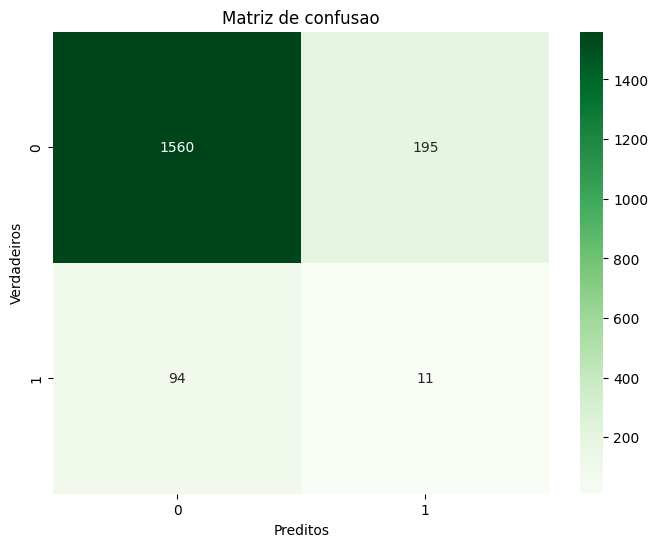

In [219]:
conf_matrix = confusion_matrix(y_test, predict)

# Plote a matriz de confusão usando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens")
plt.xlabel('Preditos')
plt.ylabel('Verdadeiros')
plt.title('Matriz de confusao')
plt.show()

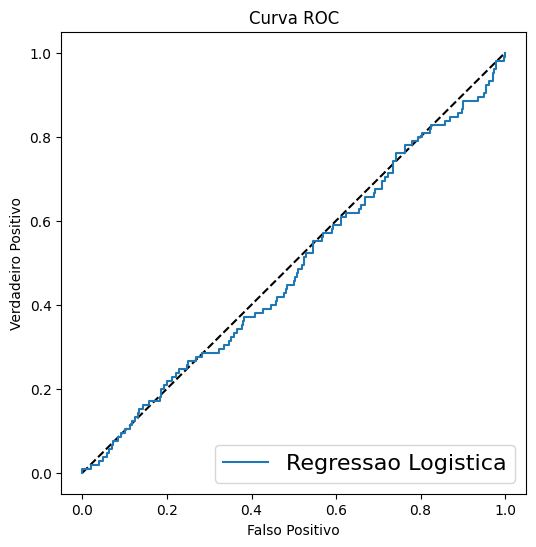

area sob a curva:  0.4850196716863384


In [220]:
y_score = pipe.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_score[:, 1])

fig = plt.figure(figsize = (6, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label = "Regressao Logistica")
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadeiro Positivo')
plt.title('Curva ROC')
plt.legend(loc="lower right", fontsize=16)
plt.show()
print('area sob a curva: ', auc(fpr, tpr))


# SVM

In [ ]:
from sklearn.svm import SVC

In [47]:
X_bal, y_bal = balanceamento()
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_bal, y_bal, test_size = 0.30, random_state = 42)

In [48]:
standard_scaler = StandardScaler()
pca = PCA(.95)

X_train_svm['idade'] = standard_scaler.fit_transform(X_train_svm['idade'].values.reshape(-1, 1))
X_test_svm['idade'] = standard_scaler.fit_transform(X_test_svm['idade'].values.reshape(-1, 1))

X_train_svm_pca = pca.fit_transform(X_train_svm)
X_test_svm_pca = pca.transform(X_test_svm)

In [49]:
modelo_svm = SVC(random_state = 42)
modelo_svm.fit(X_train_svm_pca, y_train_svm)

SVC(random_state=42)

In [ ]:
param_grid = {
                'C': [0.1, 1, 10, 100],
                'gamma': ['scale', 'auto'],
                'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
            }

           
grid_search = GridSearchCV(modelo_svm, param_grid, cv = 2, scoring='accuracy')
grid_search.fit(X_bal, y_bal)

           
print("Melhores hiperparâmetros:", grid_search.best_params_)
print("Acurácia:", grid_search.best_score_)

In [53]:
modelo_svm.score(X_test_svm_pca, y_test_svm)

0.9679351656095843

In [54]:
predict_svm = modelo_svm.predict(X_test_svm_pca)

acuracia = accuracy_score(y_test_svm, predict_svm)
acuracia

0.9679351656095843

In [55]:
print(classification_report(y_test_svm, predict_svm))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1429
           1       0.98      0.95      0.97      1409

    accuracy                           0.97      2838
   macro avg       0.97      0.97      0.97      2838
weighted avg       0.97      0.97      0.97      2838



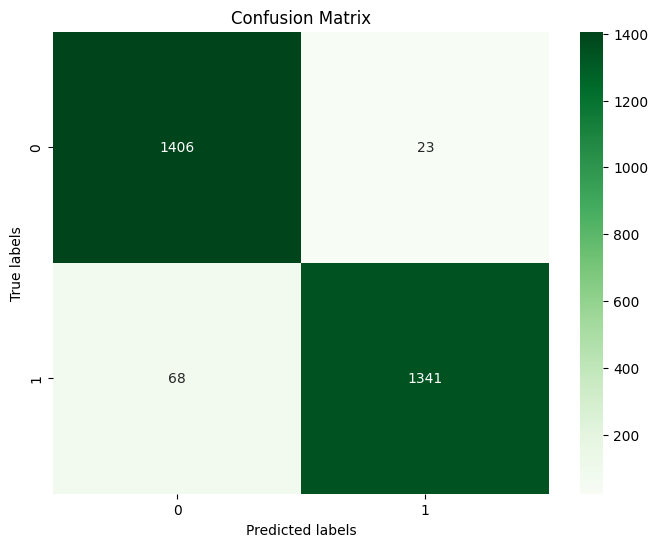

In [56]:
conf_matrix = confusion_matrix(y_test_svm, predict_svm)

# Plote a matriz de confusão usando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()  

# Arvore de Decisao

In [66]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree

In [68]:
X_bal, y_bal = balanceamento()

In [69]:
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(X_bal, y_bal, test_size = 0.30, random_state = 42)

In [70]:
standard_scaler = StandardScaler()
pca = PCA(.95)

X_train_tree['idade'] = standard_scaler.fit_transform(X_train_tree['idade'].values.reshape(-1, 1))
X_test_tree['idade'] = standard_scaler.fit_transform(X_test_tree['idade'].values.reshape(-1, 1))

X_train_tree_pca = pca.fit_transform(X_train_tree)
X_test_tree_pca = pca.transform(X_test_tree)

In [71]:
modelo_tree = DecisionTreeClassifier(random_state = 42)


In [ ]:
param_grid = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 10, 20, 30],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10]
        }

            
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)

            
print("Melhores hiperparâmetros:", grid_search.best_params_)
print("Acurácia:", grid_search.best_score_)

In [72]:
modelo_tree.fit(X_train_tree_pca,y_train_tree)

DecisionTreeClassifier(random_state=42)

In [39]:
modelo_tree.score(X_test_tree_pca, y_test_tree)

0.94375

In [73]:
predict_tree = modelo_tree.predict(X_test_tree_pca)

acuracia = accuracy_score(y_test_tree, predict_tree)
acuracia

0.9443269908386187

In [74]:
print(classification_report(y_test_tree, predict_tree))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      1429
           1       0.94      0.95      0.94      1409

    accuracy                           0.94      2838
   macro avg       0.94      0.94      0.94      2838
weighted avg       0.94      0.94      0.94      2838



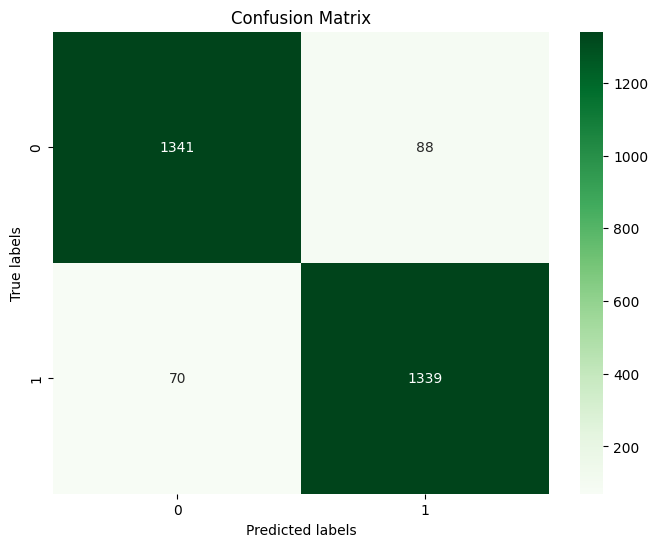

In [75]:
conf_matrix = confusion_matrix(y_test_tree, predict_tree)

# Plote a matriz de confusão usando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()  

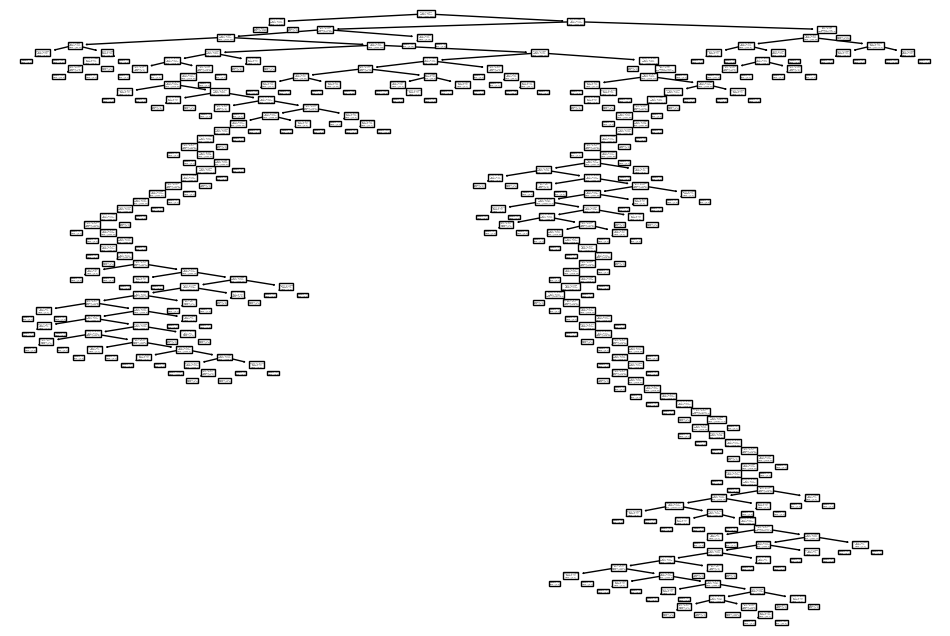

In [76]:
plt.figure(figsize = (12, 8))
tree.plot_tree(modelo_tree)
plt.show()

3. Crie uma visualização para a fronteira de decisão dos modelos acima para um dataset de resposta binária, com duas variáveis explicativas (i.e. $f(X): R \times R → \{0, 1\}$)

In [36]:
modelo_pca = LogisticRegression()
modelo_pca.fit(X_train_lr_pca, y_train_lr)

LogisticRegression()

In [ ]:
one_hot_encoder = OneHotEncoder(cols = df_transformado.drop(columns =['idade','cliente_especial']).columns.values)
df_ml = one_hot_encoder.fit_transform(df_transformado)
df_ml.head()

X = df_ml.drop(columns = 'cliente_especial')
y = df_ml['cliente_especial']

smote_bal = SMOTE(random_state = 42)

X_bal, y_bal = smote_bal.fit_resample(X, y)
X_bal.head()

In [87]:
X_bal_selected = X_bal[['emprego_atual_1', 'estado_18']]

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_bal_pca = pca.fit_transform(X_bal_selected)

from sklearn.linear_model import LogisticRegression

modelo_pca = LogisticRegression()
modelo_pca.fit(X_bal_pca, y_bal)

LogisticRegression()

C:\Users\lucas\AppData\Local\Temp\ipykernel_15548\282237306.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z[i, j] = modelo_pca.predict_proba(np.array([x, y]).reshape(1, -1))[:, 1]
C:\Users\lucas\AppData\Local\Temp\ipykernel_15548\282237306.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z[i, j] = modelo_pca.predict_proba(np.array([x, y]).reshape(1, -1))[:, 1]
C:\Users\lucas\AppData\Local\Temp\ipykernel_15548\282237306.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated 

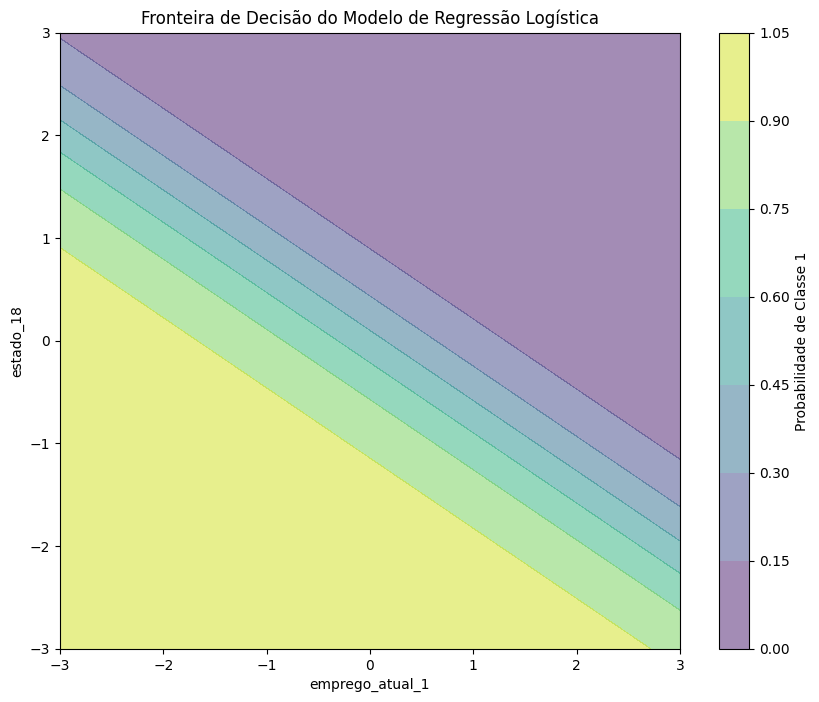

In [88]:
lim_x = np.linspace(-3, 3, 100)
lim_y = np.linspace(-3, 3, 100)

Z = np.zeros((len(lim_x), len(lim_y)))
for i, x in enumerate(lim_x):
    for j, y in enumerate(lim_y):
        Z[i, j] = modelo_pca.predict_proba(np.array([x, y]).reshape(1, -1))[:, 1]
        
plt.figure(figsize=(10, 8))
plt.contourf(lim_x, lim_y, Z, cmap='viridis', alpha=0.5)
plt.xlabel('emprego_atual_1')
plt.ylabel('estado_18')
plt.title('Fronteira de Decisão do Modelo de Regressão Logística')
plt.colorbar(label='Probabilidade de Classe 1')
plt.show()

# SVM

In [ ]:
from sklearn.svm import SVC
from mlxtend.plotting import plot_decision_regions

In [98]:
one_hot_encoder = OneHotEncoder(cols = df_transformado.drop(columns =['idade','cliente_especial']).columns.values)
df_ml = one_hot_encoder.fit_transform(df_transformado)
df_ml.head()

X = df_ml.drop(columns = 'cliente_especial')
y = df_ml['cliente_especial']

smote_bal = SMOTE(random_state = 42)

X_bal, y_bal = smote_bal.fit_resample(X, y)


In [99]:
X_bal_selected = X_bal[['emprego_atual_1', 'estado_18']]


pca = PCA(n_components=2)
X_bal_pca = pca.fit_transform(X_bal_selected)


modelo_pca_svm = SVC()
modelo_pca_svm.fit(X_bal_pca, y_bal)

SVC()

In [103]:
y_bal_np = np.array(y_bal)


# Plotar as fronteiras de decisão usando as características selecionadas
plot_decision_regions(X_bal_pca, y_bal_np, clf = modelo_pca_svm, legend=2)
plt.xlabel('emprego_atual_1')
plt.ylabel('estado_18')
plt.title('Fronteiras de Decisão do Modelo SVM')
plt.show()

# Arvore de Decisao

In [80]:
X_bal_selected = X_bal[['emprego_atual_1', 'estado_18']]


pca = PCA(n_components=2)
X_bal_pca = pca.fit_transform(X_bal_selected)


modelo_tree_pca = DecisionTreeClassifier(random_state = 42)
modelo_tree_pca.fit(X_bal_pca, y_bal)

DecisionTreeClassifier(random_state=42)

C:\Users\lucas\AppData\Local\Temp\ipykernel_15548\737930701.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z[i, j] = modelo_tree_pca.predict_proba(np.array([x, y]).reshape(1, -1))[:, 1]
C:\Users\lucas\AppData\Local\Temp\ipykernel_15548\737930701.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z[i, j] = modelo_tree_pca.predict_proba(np.array([x, y]).reshape(1, -1))[:, 1]
C:\Users\lucas\AppData\Local\Temp\ipykernel_15548\737930701.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (D

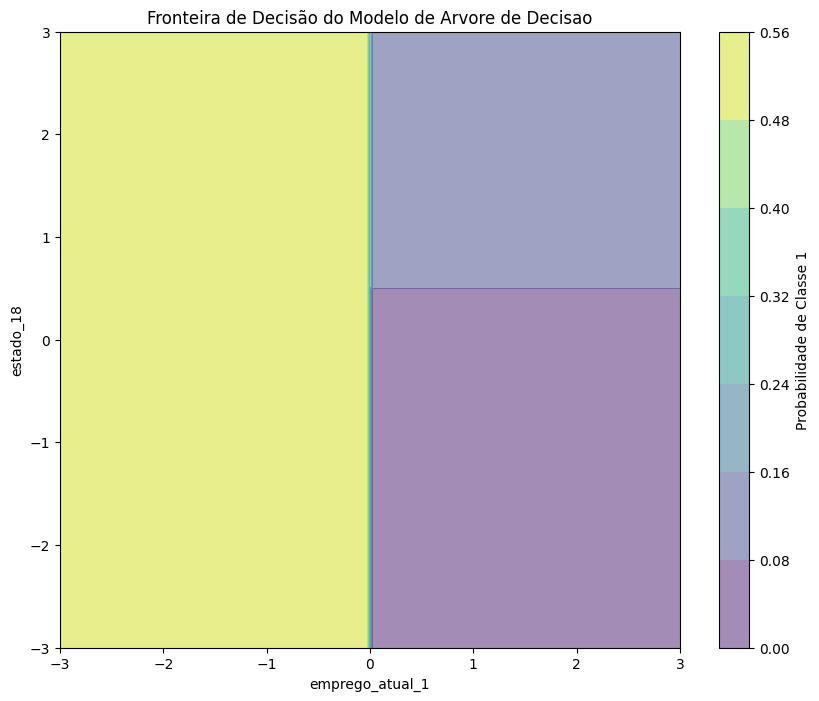

In [85]:
lim_x = np.linspace(-3, 3, 100)
lim_y = np.linspace(-3, 3, 100)

Z = np.zeros((len(lim_x), len(lim_y)))
for i, x in enumerate(lim_x):
    for j, y in enumerate(lim_y):
        Z[i, j] = modelo_tree_pca.predict_proba(np.array([x, y]).reshape(1, -1))[:, 1]
        
plt.figure(figsize=(10, 8))
plt.contourf(lim_x, lim_y, Z, cmap='viridis', alpha=0.5)
plt.xlabel('emprego_atual_1')
plt.ylabel('estado_18')
plt.title('Fronteira de Decisão do Modelo de Arvore de Decisao')
plt.colorbar(label = 'Probabilidade de Classe 1')
plt.show()